# Previsão de danos na plantação

O Objetivo desse projeto é por meio de informações de tipo de solo, pesticida e outros, classificar os danos da plantação naquela determinada safra, podendo ser classificados em:
- 0 - Sem Danos
- 1 - Danos causados por outros motivos
- 2 - Danos gerados pelos pesticidas

Antes de qualquer coisa, devemos estabelecer o plano de resolução
- Entendimento do problema
- Analise de dados
- Processamento dos dados
- Criação dos modelos
- Validação do modelo
- Predição final

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, power_transform, OneHotEncoder
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import random
import os

In [2]:
df = pd.read_csv("Safra_2018-2019.csv", index_col = 0)

In [3]:
### reproductabilidade

random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED']=str(42)

## 2. Analise e processamento dos dados

Há algumas informações importantes na documentação,
- Tipo de cultivo possui 2 tipos (0 e 1)
- Tipo de solo possui 2 tipos (0 e 1)
- Categoria do pesticida possui 3 informações (1, 2 e 3)
- Temporada climatica se resume em 3 tipos (1, 2 e 3)

Ou seja, tais variaveis são quantitativas discretas, pertencentes a um grupo finito de possibilidade, e que talvez a aplicação de algoritmos como One-Hot-Encoding tragam resultados melhores nos modelos, pois não sabemos se há ordinalidade entre as categorias e tipos

In [4]:
df.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,SCROP00005,342,1,0,1,0,0.0,0,2,1


Ademais, excluindo a identificação e o target, todas as outras variaveis são quantitativas continuas, e portanto receberão tratamentos diferentes, como a normalização dos dados, e a possivel remoção de outliers

Antes de tudo, devemos ter uma atenção a possibilidade de existencia de dados faltantes, para isso, podemos executar uma simples busca

In [5]:
df.isna().sum()

Identificador_Agricultor       0
Estimativa_de_Insetos          0
Tipo_de_Cultivo                0
Tipo_de_Solo                   0
Categoria_Pesticida            0
Doses_Semana                   0
Semanas_Utilizando          8055
Semanas_Sem_Uso                0
Temporada                      0
dano_na_plantacao              0
dtype: int64

In [6]:
df[df.isna()["Semanas_Utilizando"]].head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
5,SCROP00006,448,0,1,1,0,NaN,0,2,1
6,SCROP00007,448,0,1,1,0,NaN,0,2,1
10,SCROP00011,1212,1,0,1,0,NaN,0,3,0
17,SCROP00018,2401,0,1,1,0,NaN,0,1,1
35,SCROP00036,257,0,0,3,30,NaN,0,2,0


Como podemos ver, temos 8055 dados faltantes na coluna 'Semanas_Utilizando', esse valor representa aproximadamente 10% de todos os dados, portanto, a estrategia de exclui-los não pode ser executado, pois traria um prejuizo relacionado a perca de dados bem grande.

A primeira estrategia é saber que alguns desses dados possuem 0 Doses/Semana, o que quer dizer que não foi aplicado nenhum pesticida, portanto imputaremos 0 semanas_utilizando nesses casos.

Em seguida, podemos agrupar pela estimativa da quantidade de insetos e imputar a media de semanas utilizando


In [8]:
df[df['Doses_Semana'] == 0] = df[df['Doses_Semana'] == 0].fillna(0)

In [9]:
df['Semanas_Utilizando'] = df.groupby(['Estimativa_de_Insetos'])['Semanas_Utilizando'].apply(lambda x: x.fillna(int(x.mean())))

In [10]:
def fillna_Semanas_Utilizando(df):
    df[df['Doses_Semana'] == 0] = df[df['Doses_Semana'] == 0].fillna(0)
    df['Semanas_Utilizando'] = df.groupby(['Estimativa_de_Insetos'])['Semanas_Utilizando'].apply(lambda x: x.fillna(int(x.mean())))
    return df

In [11]:
df.isna().sum()

Identificador_Agricultor    0
Estimativa_de_Insetos       0
Tipo_de_Cultivo             0
Tipo_de_Solo                0
Categoria_Pesticida         0
Doses_Semana                0
Semanas_Utilizando          0
Semanas_Sem_Uso             0
Temporada                   0
dano_na_plantacao           0
dtype: int64

### Variavel Continua - Doses/Semana

Como podemos ver, a variavel doses/semana tem uma distribuição assimetrica para a esquerda, o que é prejudicial para alguns modelos estatisticos, no entanto, modelos como arvores de decisão conseguem lidar melhor com outliers, porem restringe nossas opções de modelos, portanto, o melhor a se fazer é aplicar uma transformação para tentar fazer com que esses dados respeitem uma distribuição normal

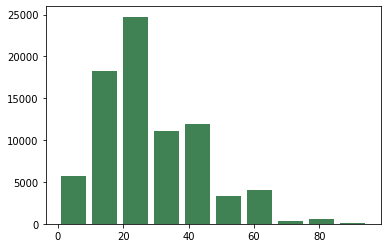

In [12]:
plt.hist(df['Doses_Semana'], rwidth = 0.8, color = "#408253")
plt.show()

(array([  763.,  4962., 10881.,  7405., 20344., 13784., 12694.,  4135.,
         4318.,   714.]),
 array([-2.8448877 , -2.26838853, -1.69188936, -1.11539019, -0.53889102,
         0.03760815,  0.61410731,  1.19060648,  1.76710565,  2.34360482,
         2.92010399]),
 <a list of 10 Patch objects>)

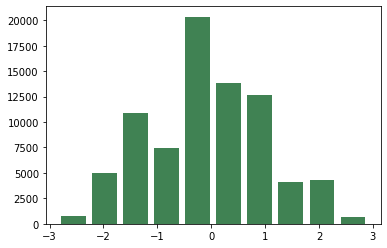

In [14]:
sc = power_transform(np.array(df['Doses_Semana']+3).reshape(-1,1), method = 'box-cox')
plt.hist(sc, color = "#408253", rwidth=0.8)

Realizando uma aritmetica em todos os dados e aplicando o metodo de box-cox, chegamos em uma distribuição bem proxima a uma distribuição normal.

Para facilitar o tratamento de diversos dados, criarei uma função responsavel pelo tratamento desse dado especifico

In [15]:
def clean_doses_semana(df2):
    df2['Doses_Semana'] = power_transform(np.array(df2['Doses_Semana']+3).reshape(-1,1), method = 'box-cox')
    return df2

### Variavel Continua - Semanas Utilizando

Novamente temos um distribuição assimetrica, no entanto, com uma assimetria bem menor, porem, realizaremos algumas operações para diminuir ainda mais essa inclinação pra esquerda da distribuição

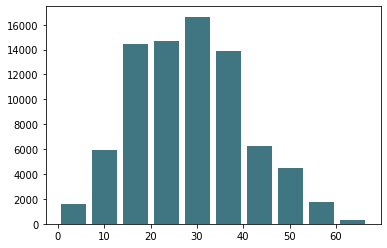

In [16]:
plt.hist(df['Semanas_Utilizando'], rwidth = 0.8, color = "#407682")
plt.show()

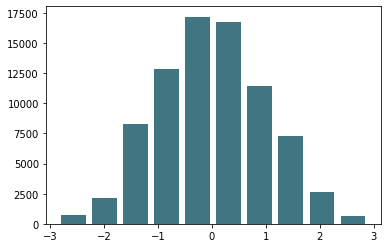

In [17]:
sc = power_transform(np.array(df['Semanas_Utilizando']+1).reshape(-1,1), method = 'box-cox')
plt.hist(sc, rwidth = 0.8, color = "#407682")
plt.show()

In [18]:
def clean_semanas_utilizando(df2):
    df2['Semanas_Utilizando'] = power_transform(np.array(df2['Semanas_Utilizando']+1).reshape(-1,1), method = 'box-cox')
    return df2

### Variavel Continua - Semanas Sem Uso

Essa variavel, possui uma assimetria muito grande proximo das 0 semanas, o que é inevitavel, porem podemos aplicar algumas transformações

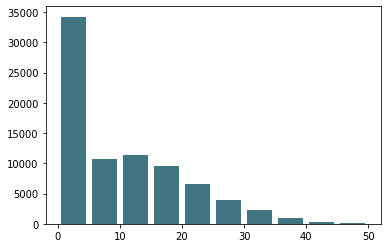

In [19]:
plt.hist(df['Semanas_Sem_Uso'], rwidth = 0.8, color = "#407682")
plt.show()

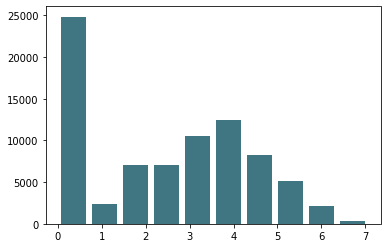

In [20]:
plt.hist(df['Semanas_Sem_Uso']**(1/2), rwidth = 0.8, color = "#407682")
plt.show()

In [21]:
def clean_semanas_Sem_Uso(df2):
    df2['Semanas_Sem_Uso'] = df2['Semanas_Sem_Uso']**(1/2)
    return df2

### Variavel Continua - Estimativa de Insetos

Novamente, uma distribuição assimetrica que precisa receber um tratamento

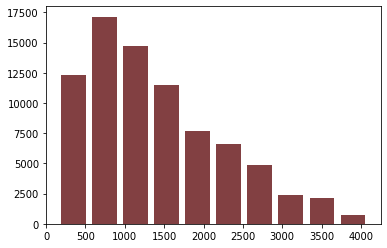

In [22]:
plt.hist(df['Estimativa_de_Insetos'], rwidth = 0.8, color = "#824042")
plt.show()

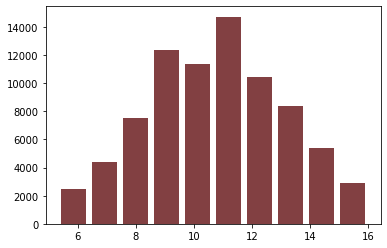

In [23]:
plt.hist(df['Estimativa_de_Insetos']**(1/3), rwidth = 0.8, color = "#824042")
plt.show()

Neste caso, batou que tirasse a raiz cubica de todos os dados para ter uma distribuição muito proxima da normal

In [24]:
def clean_estimativa_de_Insetos(df2):
    df2['Estimativa_de_Insetos'] = df2['Estimativa_de_Insetos']**(1/3)
    return df2

### Variavel Discreta - Tipo de Cultivo

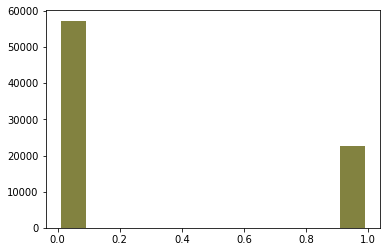

In [25]:
plt.hist(df['Tipo_de_Cultivo'], rwidth = 0.8, color = "#828240")
plt.show()

Nesse caso, não há transformações a serem feitas

### Variavel Discreta - Tipo de Solo

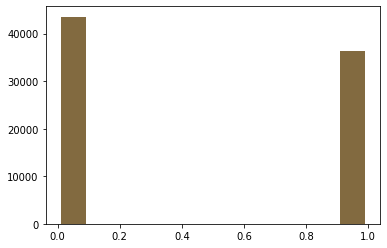

In [26]:
plt.hist(df['Tipo_de_Solo'], rwidth = 0.8, color = "#826a40")
plt.show()

### Variavel Discreta - Categoria de Pesticida

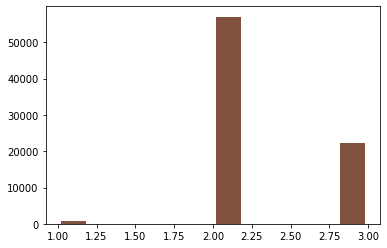

In [27]:
plt.hist(df['Categoria_Pesticida'], rwidth = 0.8, color = "#825240")
plt.show()

Como temos 3 categorias, e não sabemos se elas são ordinais, o mais correto é aplicar o algoritmo one-hot-encoding, transformando a coluna categoria de pesticida em outras 3 colunas

In [28]:
cpohe = OneHotEncoder().fit(np.array(df['Categoria_Pesticida']).reshape(-1,1))
def clean_categoria_pesticida(df2):
    encoded = cpohe.transform(np.array(df2['Categoria_Pesticida']).reshape(-1,1)).todense()
    df2 = pd.concat([df2, pd.DataFrame(encoded)], axis=1).drop(['Categoria_Pesticida'], axis=1)
    return df2

### Variavel Discreta - Temporada

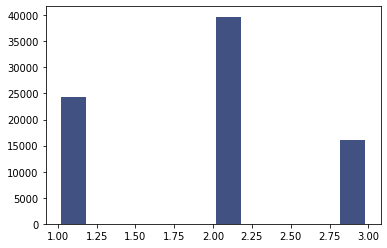

In [29]:
plt.hist(df['Temporada'], rwidth = 0.8, color = "#405182")
plt.show()

Novamente, não sabemos se há ordinalidade entre temporadas, aplicaremos o algoritmo usado anteriormente

In [30]:
tempohe = OneHotEncoder().fit(np.array(df['Temporada']).reshape(-1,1))
def clean_temporada(df2):
    encoded = tempohe.transform(np.array(df2['Temporada']).reshape(-1,1)).todense()
    df2 = pd.concat([df2, pd.DataFrame(encoded)], axis=1).drop(['Temporada'], axis=1)
    return df2

### Variavel Discreta - Danos a Plantação

Finalmente chegamos a variavel target, que sera a predição do modelo. Como podemos ver está extremamente desbalanceado e isso afetará alguns modelos estatisticos, portanto, precisamos pensar em alguns estrategias.

Podemos usar o conceito de ensemble, o qual agregaremos alguns classificadores com o objetivo de diminuir variancia e erros.

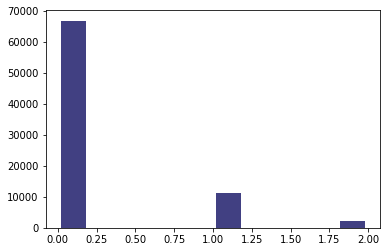

In [31]:
plt.hist(df['dano_na_plantacao'], rwidth = 0.8, color = "#414082")
plt.show()

### Pipeline

In [32]:
def pipeline(df2):
    df2 = fillna_Semanas_Utilizando(df2)
    df2 = clean_doses_semana(df2)
    df2 = clean_semanas_utilizando(df2)
    df2 = clean_semanas_Sem_Uso(df2)
    df2 = clean_estimativa_de_Insetos(df2)
    df2 = clean_categoria_pesticida(df2)
    df2 = clean_temporada(df2)
    return df2

df_processed = pipeline(df)

## 3. Modelo de Aprendizado de Maquina

Após processado todos os dados, propoe-se algumas hipoteses e as testamos.

Hipoteses a serem testadas:
- Maquina de suporte de vetores
- Naive Bayes Gaussiano
- Perceptron
- Random Forests

In [33]:
y = df_processed["dano_na_plantacao"]
X = df_processed.drop(['dano_na_plantacao', 'Identificador_Agricultor'], axis=1)


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y, random_state=42)

### Gaussian NB

In [34]:
nb = GaussianNB().fit(x_train, y_train)
f1_score(y_test, nb.predict(x_test), average="micro")

0.827225

Apesar de ser um resultado satisfatorio, podemos tentar melhorá-lo, realizando um fine-tuning

In [35]:
param = {"var_smoothing":[1e8, 1e6, 1e5, 1e3, 1e2, 0, 1e-2, 1e-4, 1e-6, 1e-8]}
gs = GridSearchCV(nb, param).fit(x_train, y_train)
f1_score(y_test, gs.predict(x_test), average="micro")

0.83395

In [36]:
gs.best_estimator_

GaussianNB(var_smoothing=100000000.0)

### SVC

In [37]:
svc = SVC(verbose = True, probability=True).fit(x_train, y_train)
f1_score(y_test, svc.predict(x_test), average="micro")

[LibSVM]

0.83915

### Random Forests

In [38]:
rf = RandomForestClassifier().fit(x_train, y_train)
f1_score(y_test, rf.predict(x_test), average="micro")

0.821925

### Perceptron

In [39]:
mlp = MLPClassifier(hidden_layer_sizes = (100,)).fit(x_train, y_train)
f1_score(y_test, mlp.predict(x_test), average="micro")

0.841925

### Voting Stacking

Com o intuito de melhorar o classificador, uniremos todos em um sistema de ensemble chamado de voting stacking, que basicamente atribui pesos e realiza uma media ponderada na probabilidade de cada classe

In [40]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

model_dict = dict(zip(['nb', 'svc', "rf", "perc"],
                      [gs, svc, rf, mlp]))

model_weights = {   
                    'nb' : 0.9,
                    'svc' : 0.8,
                    'rf': 0.5,
    'perc': 0.5,
     
 }

preds = []
y_pred_prob = 0
for model_name, model in model_dict.items():
    print(model_name)
    preds.append(model.predict_proba((x_test)))

    


nb
svc
rf
perc


In [41]:
def run_voting_clf(model_weights):    
    y_pred_prob = 0
    n=0
    for model_name, model in model_dict.items():
        y_pred_prob += (preds[n] * model_weights[model_name])
        n+=1

    y_pred_prob /= sum(model_weights.values())
    f1 = f1_score(y_test, np.argmax(y_pred_prob,axis=1), average='micro')
    return {'loss' : -f1, 'status' : STATUS_OK}


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

trials = Trials()
model_weights = fmin(run_voting_clf,
    space= {
        
        'nb' : hp.uniform('nb', 0, 1),
        'svc' : hp.uniform('svc', 0, 1),
        'rf' : hp.uniform('rf', 0, 1),
        'perc' : hp.uniform('perc', 0, 1),
       

    },
    algo=tpe.suggest,
    max_evals=2000,
    trials = trials)


100%|██████████| 2000/2000 [01:10<00:00, 28.21trial/s, best loss: -0.843425]         


Como podemos ver, a cada vez que é rodado tem-se uma combinação diferente e apos varios testes, conseguimos um score de 0.84345, maior que todos os outros modelos separadamente, e abaixo, podemos ver o peso que foi atribuido a cada modelo.

'nb': 0.01871953120627269,

'perc': 0.7784968342738109,

'rf': 0.1190089322158962,

'svc': 0.03447975258835745

In [46]:
model_weights = {'nb': 0.01871953120627269,

'perc': 0.7784968342738109,

'rf': 0.1190089322158962,

'svc': 0.03447975258835745}

Portanto, agora nos resta prever a proxima safra

## 4. Predição Final

Antes de tudo, devemos aplicar o pipeline de transformação no dataframe

In [50]:
df_predict = pd.read_csv("Safra_2020.csv", index_col = 0)
df_predict = df_predict.reset_index(drop = True)

In [51]:
df_predict_processed = pipeline(df_predict.copy())

Após, calculos a probabilidade de cada classa em cada modelo e realizamos a media ponderada

In [52]:
pred = 0

for model_name, model in model_dict.items():
    print(model_name)
    pred += model_dict[model_name].predict_proba(df_predict_processed.drop(["Identificador_Agricultor"], axis=1)) * model_weights[model_name]
    
pred = (pred)/sum(model_weights.values())

nb
svc
rf
perc


Pegamos o indice da maior probabilidade e inserimos no data frame

In [53]:
df_predict['dano_na_plantacao'] = np.argmax(pred, axis=1)
df_predict.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,SCROP80001,256,0,1,2,35,11.0,9,1,0
1,SCROP80002,283,0,1,2,5,5.0,6,1,0
2,SCROP80003,283,0,1,2,15,15.0,5,2,0
3,SCROP80004,283,0,1,2,15,NaN,7,2,0
4,SCROP80005,283,0,1,2,15,19.0,2,1,0


Salvamos e está tudo pronto!

In [58]:
df_predict.to_csv("out/Safra_2020.csv", index = False)

É possivel executar o algoritmo de maneira mais simples, por meio do seguinte comando

```bash
python classificator.py "endereco/do/arquivo/safra_20xx.csv"
```

Que irá salvar um arquivo com a predição final